# Extractive question answering

Extractive question answering involves posing question about document and identyfying the answers as spans of text on the document itself.

We will fine-tune a BERT model on the NewsQA dataset, which is dataset of over 78,000 human-generated question-answer pairs.

In [2]:
from datasets import load_dataset, Dataset, DatasetDict, load_dataset

ds = load_dataset("lucadiliello/newsqa")

Let's take a look on the dataset:

In [28]:
ds['train'][50]['question']

"Who is calling for the official's resignation?"

In [30]:
ds['train'][50]['answers']

['organizations']

In [26]:
ds['train'][50]['labels']

[{'end': [28], 'start': [16]}]

In [27]:
ds['train'][50]['context']

'(CNN) -- Jewish organizations called for a Romanian official to resign and face a criminal investigation after he wore a Nazi uniform during a fashion show over the weekend.\n\n\n\n\n\nRadu Mazare, the mayor of the town of Constanta, wore a Nazi uniform during a fashion show over the weekend.\n\n\n\n\n\nRadu Mazare, the mayor of the town of Constanta, and his 15-year-old son "entered the stage marching the clearly identifiable Nazi \'goose step,\'" the Center for Monitoring and Combating anti-Semitism in Romania said in a letter to the country\'s prosecutor general.\n\n\n\n\n\nThe organization\'s director, Marco Katz, said Mazare had broken Romanian law and encouraged his son to do the same, "educating him to treat the law with contempt."\n\n\n\n\n\nKatz said Mazare was sending a message "that to wear Nazi uniforms and to march the Nazi steps is legal and \'in vogue\' in Romania."\n\n\n\n\n\nHe urged the authorities and the head of Mazare\'s Social Democrat party to show that message 

We need to restructure the data to facilitate further processing. Let's implement the following changes:
- Remove the 'labels' section.
- Add 'answer_start' and 'answer_end' sections to the 'answer'. These values are currently named 'start' and 'end' in the 'labels' section.

In [5]:
from datasets import Dataset, DatasetDict

def split_data(dataset):
    new_rows = {
        'id': [],
        'context': [],
        'question': [],
        'answers': [],
    }
    
    for row in dataset:
        story = row['context']
        question = row['question']
        answers = row['answers']
        labels = row['labels']  
        ids = row['key']

        for answer, label in zip(answers, labels):
            new_rows['id'].append(ids)
            new_rows['context'].append(story)
            new_rows['question'].append(question)
            
            answer_dict = {
                'text': [answer],
                'answer_start': label['start'],
                'answer_end': label['end'],
            }
            new_rows['answers'].append(answer_dict)
    
    return Dataset.from_dict(new_rows)

# Assuming ds is the original DatasetDict
raw_datasets = DatasetDict({
    split: split_data(dataset) for split, dataset in ds.items()
})


Let's examine current structure and organization of our dataset to understand how it is now formatted:

In [6]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 74160
    })
    validation: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 4212
    })
})

Specific example:

In [7]:
id = 4
print('Context:', raw_datasets['train'][4]['context'])
print('Question:', raw_datasets['train'][4]['question'])
print('Answer:', raw_datasets['train'][4]['answers'])

Context: NEW DELHI, India (CNN) -- A high court in northern India on Friday acquitted a wealthy businessman facing the death sentence for the killing of a teen in a case dubbed "the house of horrors."



Moninder Singh Pandher was sentenced to death by a lower court in February.



The teen was one of 19 victims -- children and young women -- in one of the most gruesome serial killings in India in recent years.



The Allahabad high court has acquitted Moninder Singh Pandher, his lawyer Sikandar B. Kochar told CNN.



Pandher and his domestic employee Surinder Koli were sentenced to death in February by a lower court for the rape and murder of the 14-year-old.



The high court upheld Koli's death sentence, Kochar said.



The two were arrested two years ago after body parts packed in plastic bags were found near their home in Noida, a New Delhi suburb. Their home was later dubbed a "house of horrors" by the Indian media.



Pandher was not named a main suspect by investigators initial

The context and question fields are straightforward to work with. However, the answers field is more complex, as it contains a dictionary with three fields, each of which is a list. This structure is close to the format expected by the evaluation metric, with a few small adjustments.

- The text field is self-explanatory.
- The answer_start field holds the starting character index of each answer in the context.
- The answer_end field holds the ending character index of each answer in the context.

In [8]:
raw_datasets["train"].filter(lambda x: len(x["answers"]['text']) != 1) #every question has answer.

Filter:   0%|          | 0/74160 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'context', 'question', 'answers'],
    num_rows: 0
})

Now that the dataset is structured with each example containing one story, one question, and one answer, we can move on to the tokenization part. 

# Tokenization
We are passing context and question together and it will properly insert tokens to form a sentence like this: [CLS] question [SEP] context [SEP] <br>
As mentioned previously, we’ll be fine-tuning a BERT model.

In [9]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [10]:
vocab_size = len(tokenizer)
print(f"The tokenizer contains {vocab_size} tokens.")

The tokenizer contains 28996 tokens.


Let's double check if the form of the sentences is as expected:

In [11]:
context = raw_datasets["train"][5]["context"]
question = raw_datasets["train"][5]["question"]

inputs = tokenizer(question, context)
print(tokenizer.decode(inputs["input_ids"]))

[CLS] What was Moninder Singh Pandher acquitted for? [SEP] NEW DELHI, India ( CNN ) - - A high court in northern India on Friday acquitted a wealthy businessman facing the death sentence for the killing of a teen in a case dubbed " the house of horrors. " Moninder Singh Pandher was sentenced to death by a lower court in February. The teen was one of 19 victims - - children and young women - - in one of the most gruesome serial killings in India in recent years. The Allahabad high court has acquitted Moninder Singh Pandher, his lawyer Sikandar B. Kochar told CNN. Pandher and his domestic employee Surinder Koli were sentenced to death in February by a lower court for the rape and murder of the 14 - year - old. The high court upheld Koli's death sentence, Kochar said. The two were arrested two years ago after body parts packed in plastic bags were found near their home in Noida, a New Delhi suburb. Their home was later dubbed a " house of horrors " by the Indian media. Pandher was not nam

The labels will then be the index of the tokens starting and ending the answer, and the model will be tasked to predicted one start and end logit per token in the input, with the theoretical labels being as follows: <br>
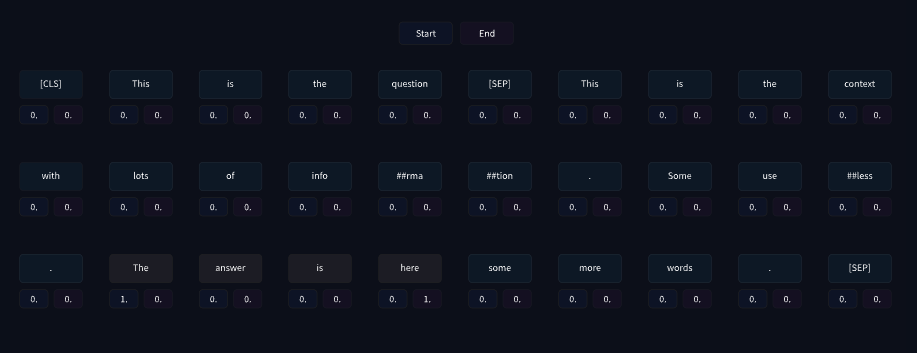

Some of the examples in the dataset have very long contexts that will exceed the maximum length we set (which is 384 in this case). We will deal with long contexts by creating several training features from one sample of our dataset, with a sliding window between them.
To see how this works using the current example, we can limit the length to 100 and use a sliding window of 50 tokens. We use:

- max_length to set the maximum length (here 100)
- truncation="only_second" to truncate the context (which is in the second position) when the question with its context is too long
- stride to set the number of overlapping tokens between two successive chunks (here 50)
- return_overflowing_tokens=True to let the tokenizer know we want the overflowing tokens

In [463]:
#check the lenght of question + answer in terms of tensors
lenght_tokens = []
for i in range(len(raw_datasets['train'])):
    context = raw_datasets['train'][i]["context"]
    question = raw_datasets['train'][i]["question"]
    inputs = tokenizer(question, context)
    inputs_id = inputs['input_ids']
    lenght = len(inputs_id)
    lenght_tokens.append(lenght)


sorted_lengths = sorted(lenght_tokens)


Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors


In [694]:
sorted_lengths[-10:]

[1073, 1073, 1073, 1074, 1078, 1080, 1084, 1084, 1090, 1149]

The longest vectors with story + question encoded as tokens exceed 1100. 



In [12]:
#lets look at the example
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

[CLS] What was Moninder Singh Pandher acquitted for? [SEP] NEW DELHI, India ( CNN ) - - A high court in northern India on Friday acquitted a wealthy businessman facing the death sentence for the killing of a teen in a case dubbed " the house of horrors. " Moninder Singh Pandher was sentenced to death by a lower court in February. The teen was one of 19 victims - - children and young women - - in one of the most grue [SEP]
[CLS] What was Moninder Singh Pandher acquitted for? [SEP] a case dubbed " the house of horrors. " Moninder Singh Pandher was sentenced to death by a lower court in February. The teen was one of 19 victims - - children and young women - - in one of the most gruesome serial killings in India in recent years. The Allahabad high court has acquitted Moninder Singh Pandher, his lawyer Sikandar B. Kochar told CNN. Pan [SEP]
[CLS] What was Moninder Singh Pandher acquitted for? [SEP] - children and young women - - in one of the most gruesome serial killings in India in recent

As we can see, our example has been split into seven inputs, each containing the question and some part of the context. Note that the answer to the question (“the killing of a teen”) only appears in the first input. By dealing with long contexts in this way, we will create some training examples where the answer is not included in the context. For those examples, the labels will be start_position = end_position = 0 (so we predict the [CLS] token). We will also set these labels in the unfortunate case where the answer has been truncated, meaning we only have the start or end of it. For the examples where the answer is fully in the context, the labels will be the index of the token where the answer starts and the index of the token where the answer ends.



To map start_position and end_position to token indicies, we will use the offset mappings. We can have our tokenizer return these by passing along return_offsets_mapping=True:

In [31]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'overflow_to_sample_mapping'])

In [32]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

In [33]:
print(f"The 1 examples gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")
print(f"Offset mapping: {inputs['offset_mapping']}.")


The 1 examples gave 7 features.
Here is where each comes from: [0, 0, 0, 0, 0, 0, 0].
Offset mapping: [[(0, 0), (0, 4), (5, 8), (9, 12), (12, 17), (18, 23), (24, 27), (27, 29), (29, 31), (32, 41), (42, 45), (45, 46), (0, 0), (0, 2), (2, 3), (4, 6), (6, 7), (7, 8), (8, 9), (9, 10), (11, 16), (17, 18), (18, 21), (21, 22), (23, 24), (24, 25), (26, 27), (28, 32), (33, 38), (39, 41), (42, 50), (51, 56), (57, 59), (60, 66), (67, 76), (77, 78), (79, 86), (87, 98), (99, 105), (106, 109), (110, 115), (116, 124), (125, 128), (129, 132), (133, 140), (141, 143), (144, 145), (146, 150), (151, 153), (154, 155), (156, 160), (161, 167), (168, 169), (169, 172), (173, 178), (179, 181), (182, 188), (188, 189), (189, 190), (190, 191), (195, 198), (198, 203), (204, 209), (210, 213), (213, 215), (215, 217), (218, 221), (222, 231), (232, 234), (235, 240), (241, 243), (244, 245), (246, 251), (252, 257), (258, 260), (261, 269), (269, 270), (274, 277), (278, 282), (283, 286), (287, 290), (291, 293), (294, 296),

We tokenized only one example, we get list of 0 - index which tells us to which example feature belongs.

Let's tokenize more examples

In [34]:
inputs = tokenizer(
    raw_datasets['train'][2:6]["question"],
    raw_datasets['train'][2:6]["context"],
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

print(f"The 4 examples gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")

The 4 examples gave 27 features.
Here is where each comes from: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3].


As we can see 1st example gave 8 features, 2nd example 6 features, 3rd example 6 features, 4th example 7 features.

This information will be useful to map each feature we get to its corresponding label:
- (0, 0) if the answer is not in the corresponding span of the context
- (start_position, end_position) if the answer is in the corresponding span of the context, with start_position being the index of the token (in the input IDs) at the start of the answer and end_position being the index of the token (in the input IDs) where the answer ends

To determine which of these is the case and, if relevant, the positions of the tokens, we first find the indices that start and end the context in the input IDs. We could use the token type IDs to do this, but since those do not necessarily exist for all models (DistilBERT does not require them, for instance), we’ll instead use the sequence_ids() method of the BatchEncoding our tokenizer returns.

Once we have those token indices, we look at the corresponding offsets, which are tuples of two integers representing the span of characters inside the original context. We can thus detect if the chunk of the context in this feature starts after the answer or ends before the answer begins (in which case the label is (0, 0)). If that’s not the case, we loop to find the first and last token of the answer:

In [35]:
answers = raw_datasets["train"][2:6]["answers"]
start_positions = []
end_positions = []

#inputs["offset_mapping"] - zaczyna się od pytania w przypadku [1:3], mamy pytanie 

# 'What is in front of = które jest zapisane w offset_mapping jako (0, 0),(0, 4),(5, 7),(8, 10),(11, 16)
#czyli to są tokeny np. Architecturally - to dwa tokeny (0, 13),(13, 15)

#context start: po którym tokenie zaczyna się context. Czyli liczymy ile tokenów ma pytanie i po pytaniu zaczyna się context w naszym przypadku:
# 'What is in front of the Notre Dame Main Building?' = 13 tokenów - [(0, 0),(0, 4),(5, 7),(8, 10)(11, 16),(17, 19),(20, 23),(24, 29),(30, 34),(35, 39),(40, 48),(48, 49),(0, 0).
for i, offset in enumerate(inputs["offset_mapping"]):
    sample_idx = inputs["overflow_to_sample_mapping"][i] #determines example
    answer = answers[sample_idx]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_end"][0] #determines where we can find answer in the context
    sequence_ids = inputs.sequence_ids(i) #gave 'labels' to the tensor in question = 0, tensort in context = 1

    # Find the start and end of the context [idexes]
    idx = 0 #sequence_ids[1] gave the label 0, since first tensor belongs to question. 
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label is (0, 0)
    #len(offset) = 100 atmost, depednign whether there is enough tensor in context. 3
    #offset - each tensor in the input is assigned to pair(x,y), where x is position of first character which belongs to tensor and y is the last one.
    # we process with each offset and we are assigning label to it.

    #jezeli offset[context_start][0] > start_char, czyli patrzymy na offset który rozpoczyna context - jest to 13 token. Jeżeli start_char był wcześniej to przypisujemy label (0,0), 
    # podobnie dla context_end, jeżeli context kończy się przed uzyskaniem pełnej odpowiedzi to mamy (0,0)
    
    # If the answer is not fully inside the context, label is (0, 0)


    if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
        start_positions.append(0)
        end_positions.append(0)
    else:

        # Otherwise it's the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)
#jeżeli odpowiedź jest w kontekście to jako label dajemy pozycję gdzie sie zaczyna odpowiedź i gdzie się konczy w formacie (x,y)
print(start_positions)
print(end_positions)

[0, 0, 0, 65, 33, 0, 0, 0, 52, 8, 0, 0, 0, 0, 52, 8, 0, 0, 0, 0, 43, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 67, 35, 0, 0, 0, 57, 13, 0, 0, 0, 0, 57, 13, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0]


Let’s take a look at a few results to verify that our approach is correct. For the fourth feature we find (63, 65) as labels, so let’s compare the theoretical answer with the decoded span of tokens from 63 to 65 (inclusive):

In [54]:
idx = 3 #idx of feature
sample_idx = inputs["overflow_to_sample_mapping"][idx] #idx of example for given feature
theoretical_answer  = answers[sample_idx]

start = start_positions[idx]
end = end_positions[idx]
labeled_answer = tokenizer.decode(inputs['input_ids'][idx][start:end+1])

print('theoretical_answer', theoretical_answer['text'], 'labeled_answer:', labeled_answer )

theoretical_answer ['rape and murder'] labeled_answer: rape and murder


So that’s a match! 

Now that we have seen step by step how to preprocess our training data, we can group it in a function we will apply on the whole training dataset. We’ll pad every feature to the maximum length we set, as most of the contexts will be long (and the corresponding samples will be split into several features):

In [55]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []


    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i] #index of example (couple of features can have the same index because they can come from the same example)
        answer = answers[sample_idx] #each example have one answer, this answer is assigned to each feature which came from given example.
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i) #None if [CEP] or [SEP], 0 if question token, 1 if story token
        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [56]:
train_dataset = raw_datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
len(raw_datasets["train"]), len(train_dataset)

Map:   0%|          | 0/74160 [00:00<?, ? examples/s]

(74160, 198507)

### train_dataset:
 - input_ids - ids of tokens 
 - tokens_type_ids - 0- question, 1 - context
 - attention_mask -  1 -if  context and question tokens, 0 - padding.
 - start_positions - position in the context of first token of the answer
 - end_positions - position in the context of last token of the answer

In [57]:
train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 198507
})

In [58]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

## Processing the validation data

In [60]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [61]:
validation_dataset = raw_datasets["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)
len(raw_datasets["validation"]), len(validation_dataset)

Map:   0%|          | 0/4212 [00:00<?, ? examples/s]

(4212, 11231)

### validation_dataset
- input_ids - ids of tokens
- token_type_ids - 0 question, 1 context
- attention_mask - 1 - if  context and question tokens, 0 - padding.
- offset mapping - None for questions, for context [0, 5],[6, 10],[11, 13],[14, 17] etc. For example: the token span [5,8] indicates that the token begins at the 5th character position in the context and ends at the 8th character position.

Multiple rows in validation_set can have the same example_id, it happens when number of tokens produce from question+answer text exceeds 384 tokens.

In [62]:
from collections import Counter
validation_dataset['example_id']

# Get counts
counts = Counter(validation_dataset['example_id'])

# Print the counts
print(counts)

Counter({'1f92d606a35b4cccae34b03477b7f88b': 4, '3ae1b671353c41eb9fb31fc466e14155': 4, '67a5828b6f5c4b7cbffe811a9e18290d': 4, '05fd8aeb14d24b5fbb59d596f4aebf8a': 4, '4829965548f840809e931e6b957f085c': 4, '7e8255671f0a4fbd88c688b4e6b2bee8': 4, '739854dee1cc4fbc991ea07a0e593389': 4, '53c67cb7647d4cc4bb23eaf2d317008d': 4, 'd34861cb019d4deaaeaa08250ca1b4fc': 4, 'fee8b22532204c5c87bb96182e128d56': 4, 'ebc8ddb0bc9e409e88de995ce9a063ab': 4, '3811aec484274bd99fb8231b001e9e02': 4, '6ecfb1c98af64534bda5385ce6253550': 4, '7c9c76f0655142e8b33e0448f3f94777': 4, '37b9919bd53e4cd8ad12b4a1d646bf36': 4, '3e4c8a8c9e174680a247362b4b0fe77c': 4, '01ea084994484e5caa8c9cb317cb11a5': 4, '8e54fc7e65e14768a22401ac648db015': 4, '194a8ecbcf0d4d17b469be92d066ad93': 4, '708781de86994f85a8cf27d7d4d9552a': 4, '815cf0a1a5dd4a31b9b6b94e62e31435': 4, 'f9d580fe51264fe1948adba52d906ee5': 4, '5252a53cef7d419a8ea37a3beb22e2fa': 4, '4c426e2c625f463f858241fbb08db079': 4, '2ffae4c1a213448c93aae455b39ac77b': 4, '1d20e69e95bb407

In [63]:
val_dataset_ex = validation_dataset.filter(lambda example: example['example_id'] == '1f92d606a35b4cccae34b03477b7f88b')

Filter:   0%|          | 0/11231 [00:00<?, ? examples/s]

In [64]:
val_dataset_ex['offset_mapping'][2][380:]

[[3947, 3951], [3951, 3952], [3958, 3964], None]

In [65]:
print(len(validation_dataset['example_id']))
print(len(set(validation_dataset['example_id']))) #todo

11231
4212


## Fine-tuning the model with the Trainer API

##### Post-processing

The model will output logits for the start and end positions of the answer in the input IDs. The post-processing step:
- We masked the start and end logits corresponding to tokens outside of the context.
- We take 20 highest logits within start_token and end_token predicted logits, and we assign scores to chosen pairs (start_token,end_token) by taking the sum of the start and end logits and we looked for the pair with the maximum score.

To demonstrate all of this, we will need some kind of predictions. Since we have not trained our model yet, we are going to use the default model for the QA pipeline to generate some predictions on a small part of the validation set. We can use the same processing function as before; because it relies on the global constant tokenizer, we just have to change that object to the tokenizer of the model we want to use temporarily:


In [66]:
small_eval_set = raw_datasets["validation"].select(range(100))
trained_checkpoint = "distilbert-base-cased-distilled-squad"

tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)
eval_set = small_eval_set.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Now that the preprocessing is done, we change the tokenizer back to the one we originally picked:

In [68]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [71]:
import torch
from transformers import AutoModelForQuestionAnswering

eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("torch")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}
trained_model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint).to(
    device
)

with torch.no_grad():
    outputs = trained_model(**batch)

In [ ]:
start_logits = outputs.start_logits.cpu().numpy()
end_logits = outputs.end_logits.cpu().numpy()

Now, we need to find the predicted answer for each example in our small_eval_set. One example may have been split into several features in eval_set, so the first step is to map each example in small_eval_set to the corresponding features in eval_set:

In [75]:
import collections

example_to_features = collections.defaultdict(list)
for idx, feature in enumerate(eval_set):
    example_to_features[feature["example_id"]].append(idx)

In [80]:
example_to_features

defaultdict(list,
            {'849240180c584f71bc56c0c92c5df5fd': [0],
             '8da0d6902cab4114b140672981c41ece': [1],
             'fb575e95e21843f9bc7ab8acdde72ee7': [2],
             'fc754599d5c048639de9864adbce649a': [3],
             'f7b2f89be1724a9c86cbcc347b0c4425': [4],
             '342cb6f69f6449318f4c4e5385f954fd': [5],
             'f2f07af9f9874dc992ca32c22063ffd4': [6],
             '365c5a43bd704e5bb1bc9e49d28bcf24': [7, 8, 9],
             'd37eef3f1e014b2ebbd84db0e0fd9012': [10, 11, 12],
             'ffef7cbb9e7e4526a9826d07cb730fcd': [13, 14, 15],
             '63fdd20036c74bc585e0a089ac9317df': [16, 17, 18],
             '9d57e430e4bd40e6ab55ba4940df4767': [19, 20, 21],
             '1cc0e6b7eaa7409bb2455f1780bb777b': [22, 23, 24],
             '014e5f5a9a98493ba20e29a3a4c478a5': [25, 26, 27],
             'a5ad768fcc80413387ef56a790b3940f': [28, 29, 30],
             '5c1f77d8de6c4a3886d9fa099e0bc0a0': [31, 32, 33],
             '9a9e86c0ad0a4a2db791d4f5fd

With this in hand, we can really get to work by looping through all the examples and, for each example, through all the associated features. As we said before, we’ll look at the logit scores for the n_best start logits and end logits, excluding positions that give:

- An answer that wouldn’t be inside the context
- An answer with negative length
- n answer that is too long (we limit the possibilities at max_answer_length=30)

Once we have all the scored possible answers for one example, we just pick the one with the best logit score:

In [2]:
from collections import Counter
validation_dataset['example_id']

# Get counts
counts = Counter(eval_set['example_id'])

# Print the counts
print(counts)

NameError: name 'validation_dataset' is not defined

In [102]:
#tutaj uzywamy modelu jakiegos losowego do wygnerowania odpowiedzi, czyli on dostaje exmaple, dzieli go na featury i kazdy feature analizuej osobno, potem laczy to 
#po example id i ze wszystkich par logitsów ktore maja to samo id wybiera te dwa logitsy ktore smaja najwiekszy score sumarycznie i spelniaja jakies warunki. 
import numpy as np

n_best = 20
max_answer_length = 30
predicted_answers = []

for example in small_eval_set:
    example_id = example["id"] #get unique 'id' of example
    context = example["context"] 
    answers = []

    for feature_index in example_to_features[example_id]: #loop through the features generated from given example_id
        start_logit = start_logits[feature_index] #start logits for given feature
        end_logit = end_logits[feature_index] #end logits for given feature
        offsets = eval_set["offset_mapping"][feature_index] #len 384, 'NONE' for questin, (x,y) for context, 
        #where x position of first character of the token in the context, y position of last character of the token in the context

        start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
        end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
        for start_index in start_indexes:
            for end_index in end_indexes:
                # Skip answers that are not fully in the context
                if offsets[start_index] is None or offsets[end_index] is None: #
                    continue
                # Skip answers with a length that is either < 0 or > max_answer_length.
                if (
                    end_index < start_index
                    or end_index - start_index + 1 > max_answer_length
                ):
                    continue

                answers.append(
                    {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                )

    best_answer = max(answers, key=lambda x: x["logit_score"])
    predicted_answers.append({"id": example_id, "prediction_text": best_answer["text"]})

In [105]:
predicted_answers

[{'id': '849240180c584f71bc56c0c92c5df5fd',
  'prediction_text': 'environmental efforts'},
 {'id': '8da0d6902cab4114b140672981c41ece',
  'prediction_text': 'environmental efforts'},
 {'id': 'fb575e95e21843f9bc7ab8acdde72ee7', 'prediction_text': 'eco videos'},
 {'id': 'fc754599d5c048639de9864adbce649a', 'prediction_text': 'chest'},
 {'id': 'f7b2f89be1724a9c86cbcc347b0c4425',
  'prediction_text': 'Harrison Ford'},
 {'id': '342cb6f69f6449318f4c4e5385f954fd', 'prediction_text': 'iReport form'},
 {'id': 'f2f07af9f9874dc992ca32c22063ffd4',
  'prediction_text': 'featured videos'},
 {'id': '365c5a43bd704e5bb1bc9e49d28bcf24',
  'prediction_text': 'Egyptian striker'},
 {'id': 'd37eef3f1e014b2ebbd84db0e0fd9012',
  'prediction_text': 'Wigan Athletic'},
 {'id': 'ffef7cbb9e7e4526a9826d07cb730fcd',
  'prediction_text': 'Wigan Athletic'},
 {'id': '63fdd20036c74bc585e0a089ac9317df', 'prediction_text': 'fine'},
 {'id': '9d57e430e4bd40e6ab55ba4940df4767', 'prediction_text': 'Adriano'},
 {'id': '1cc0e6b7e

The final format of the predicted answers is the one that will be expected by the metric we will use.

In [1]:
import evaluate

metric = evaluate.load("squad")

: 

We need to apply one change to the small_eval_set to properly evalulate model, we need to get rid of 'answer_end'.

In [108]:
new_answers = [{'text': ans['text'], 'answer_start': ans['answer_start']} for ans in small_eval_set['answers']]
# Creating the new dataset elo1 by removing answer_end
small_eval_set_adjust_dict = {
    'id': small_eval_set['id'],
    'context': small_eval_set['context'],
    'question': small_eval_set['question'],
    'answers': new_answers
}

small_eval_set_adjust = Dataset.from_dict(small_eval_set_adjust_dict)

# Checking the structure of elo1
print(small_eval_set_adjust)
print(small_eval_set_adjust['answers'])

Dataset({
    features: ['id', 'context', 'question', 'answers'],
    num_rows: 100
})
[{'answer_start': [1152], 'text': ['three different videos']}, {'answer_start': [891], 'text': ['getting his chest waxed,']}, {'answer_start': [1429], 'text': ['environmental']}, {'answer_start': [899], 'text': ['his chest']}, {'answer_start': [877], 'text': ['Harrison Ford']}, {'answer_start': [1479], 'text': ['Use the iReport form']}, {'answer_start': [1220], 'text': ['think are the best.']}, {'answer_start': [861], 'text': ['unprofessional.']}, {'answer_start': [134], 'text': ['Wigan Athletic']}, {'answer_start': [134], 'text': ['Wigan Athletic']}, {'answer_start': [995], 'text': ['a fine']}, {'answer_start': [1605], 'text': ['Adriano']}, {'answer_start': [111], 'text': ['President Obama']}, {'answer_start': [850], 'text': ['35,000.']}, {'answer_start': [890], 'text': ['6,000']}, {'answer_start': [49], 'text': ['to commit more U.S. troops to the ongoing war in Afghanistan,']}, {'answer_start': [89

Let's prepare theoretical answers in the required format:

In [109]:
theoretical_answers = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in small_eval_set_adjust
]

In [112]:
idx = 11
#print('question:', raw_datasets["validation"]['context'][idx])
print('question:', raw_datasets["validation"]['question'][idx])
print('theoretical answer:', raw_datasets["validation"]['answers'][idx])
print('predicted answer', predicted_answers[idx])

question: Who went missing for two weeks and said he was taking a break from football?
theoretical answer: {'answer_end': [1611], 'answer_start': [1605], 'text': ['Adriano']}
predicted answer {'id': '9d57e430e4bd40e6ab55ba4940df4767', 'prediction_text': 'Adriano'}


In [113]:
metric.compute(predictions=predicted_answers, references=theoretical_answers)

{'exact_match': 41.0, 'f1': 52.330143844033024}

Now let’s put everything we just did in a compute_metrics() function that we will use in the Trainer. Normally, that compute_metrics() function only receives a tuple eval_preds with logits and labels. Here we will need a bit more, as we have to look in the dataset of features for the offset and in the dataset of examples for the original contexts, so we won’t be able to use this function to get regular evaluation results during training. We will only use it at the end of training to check the results.

The compute_metrics() function groups the same steps as before; we just add a small check in case we don’t come up with any valid answers (in which case we predict an empty string).

In [114]:
from tqdm.auto import tqdm


def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [
    {"id": ex["id"], 'answers': {'text': ex['answers']['text'], 'answer_start': ex['answers']['answer_start']}} for ex in examples]
    return predicted_answers, theoretical_answers, metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [116]:
predicted_answers, theoretical_answer, metrics = compute_metrics(start_logits, end_logits, eval_set, small_eval_set_adjust)
metrics

  0%|          | 0/100 [00:00<?, ?it/s]

{'exact_match': 41.0, 'f1': 52.330143844033024}

Values are the same as before, so we are good.

### Fine-tuning the model

We are now ready to train our model. Let’s create it first, using the AutoModelForQuestionAnswering class like before:

In [117]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Logging in to Hugging Face in order to have possibility to push model to Hub.

In [118]:
from huggingface_hub import notebook_login

notebook_login()

We can define our TrainingArguments.
We set hyperparameters (learning rate, number of epochs, weight decay). We want to save the model at the end of every epoch, skip evaluation and upload results to the Model Hub. We also enable mixed-precision training with fp16=True. 

In [119]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-newsqa",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=5,  # Increase number of epochs to allow further fine-tuning
    weight_decay=0.01,
    fp16=True, #mixed-precision training
    push_to_hub=True,
    max_grad_norm=1.0,  # Apply gradient clipping
    lr_scheduler_type="cosine_with_restarts",  # Change to cosine annealing scheduler
)

c:\Users\Kuba\proba\.venv\Lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Pass everything to trainer.

In [523]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)
trainer.train()

  0%|          | 0/74442 [00:00<?, ?it/s]

c:\Users\Kuba\proba\.venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 2.2817, 'grad_norm': 18.244731903076172, 'learning_rate': 1.9866741893017386e-05, 'epoch': 0.02}
{'loss': 1.5594, 'grad_norm': 14.837904930114746, 'learning_rate': 1.973267778941995e-05, 'epoch': 0.04}
{'loss': 1.3683, 'grad_norm': 25.254770278930664, 'learning_rate': 1.9598345020284252e-05, 'epoch': 0.06}
{'loss': 1.3049, 'grad_norm': 22.93838882446289, 'learning_rate': 1.9464012251148547e-05, 'epoch': 0.08}
{'loss': 1.2298, 'grad_norm': 28.271320343017578, 'learning_rate': 1.9329679482012845e-05, 'epoch': 0.1}
{'loss': 1.2545, 'grad_norm': 9.45107364654541, 'learning_rate': 1.919534671287714e-05, 'epoch': 0.12}
{'loss': 1.205, 'grad_norm': 20.3270263671875, 'learning_rate': 1.9061013943741438e-05, 'epoch': 0.14}
{'loss': 1.1943, 'grad_norm': 20.450721740722656, 'learning_rate': 1.8926681174605733e-05, 'epoch': 0.16}
{'loss': 1.1506, 'grad_norm': 20.547119140625, 'learning_rate': 1.879234840547003e-05, 'epoch': 0.18}
{'loss': 1.1519, 'grad_norm': 20.428550720214844, 'learning

TrainOutput(global_step=74442, training_loss=0.729746085780551, metrics={'train_runtime': 14118.294, 'train_samples_per_second': 42.181, 'train_steps_per_second': 5.273, 'total_flos': 1.167057794011346e+17, 'train_loss': 0.729746085780551, 'epoch': 3.0})

Training takes some time, over 3 hours on my GPU. We can use model which I have trained by loading it like that:

In [122]:
from transformers import Trainer
from accelerate import Accelerator
from transformers import AutoTokenizer, AutoModelForQuestionAnswering


tokenizer = AutoTokenizer.from_pretrained("kubabp9/newsqa")
model = AutoModelForQuestionAnswering.from_pretrained("kubabp9/newsqa")
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)

from accelerate import Accelerator

# Initialize the accelerator
accelerator = Accelerator()

Each time model is saved (every epoch in our case) it is uploaded to the HUB in the background. 

Once the training is complete, we can finally evaluate our model, but before that we need to apply similar adjustments to the raw_validation_dataset as we did when we were evalulating small_eval_set - we need to get rid of 'answer_end'.

In [123]:
new_answers = [{'text': ans['text'], 'answer_start': ans['answer_start']} for ans in raw_datasets["validation"]['answers']]
# Creating the new dataset elo1 by removing answer_end
raw_datasets_validation_dict = {
    'id':  raw_datasets["validation"]['id'],
    'context':  raw_datasets["validation"]['context'],
    'question':  raw_datasets["validation"]['question'],
    'answers': new_answers
}

raw_datasets_validation_adjust = Dataset.from_dict(raw_datasets_validation_dict)

# Checking the structure of elo1
print(raw_datasets_validation_adjust)
print(raw_datasets_validation_adjust['answers'])

Dataset({
    features: ['id', 'context', 'question', 'answers'],
    num_rows: 4212
})
[{'answer_start': [1152], 'text': ['three different videos']}, {'answer_start': [891], 'text': ['getting his chest waxed,']}, {'answer_start': [1429], 'text': ['environmental']}, {'answer_start': [899], 'text': ['his chest']}, {'answer_start': [877], 'text': ['Harrison Ford']}, {'answer_start': [1479], 'text': ['Use the iReport form']}, {'answer_start': [1220], 'text': ['think are the best.']}, {'answer_start': [861], 'text': ['unprofessional.']}, {'answer_start': [134], 'text': ['Wigan Athletic']}, {'answer_start': [134], 'text': ['Wigan Athletic']}, {'answer_start': [995], 'text': ['a fine']}, {'answer_start': [1605], 'text': ['Adriano']}, {'answer_start': [111], 'text': ['President Obama']}, {'answer_start': [850], 'text': ['35,000.']}, {'answer_start': [890], 'text': ['6,000']}, {'answer_start': [49], 'text': ['to commit more U.S. troops to the ongoing war in Afghanistan,']}, {'answer_start': [8

In [124]:
predictions, _, _ = trainer.predict(validation_dataset)
start_logits, end_logits = predictions
predicted_answers_1, theoretical_answers_1, metrics = compute_metrics(start_logits, end_logits, validation_dataset,raw_datasets_validation_adjust)

c:\Users\Kuba\proba\.venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/1404 [00:00<?, ?it/s]

  0%|          | 0/4212 [00:00<?, ?it/s]

In [125]:
metrics 

{'exact_match': 51.87559354226021, 'f1': 66.51803911094837}

Great, our final metric is: {'exact_match': 51.87559354226021, 'f1': 66.51803911094837}. 

But let's take a closer look to the results. 

In [126]:
def print_wrong_predictions(list1, list2):
    # Initialize counter
    wrong_predictions = []
    # Iterate through both lists element-wise
    for theory, predicted in zip(list1, list2):
        # Split each string into a set of lowercase words to avoid case-sensitivity issues
        words1 = set(theory['answers']['text'][0].lower().split())
        words2 = set(predicted['prediction_text'].lower().split())

        # Check for any overlap
        if words1.issubset(words2) or words2.issubset(words1):
            continue
        else:
            wrong_predictions.append({
                'id': theory['id'],
                'theoretical_answer': theory['answers']['text'][0],
                'predicted_answer': predicted['prediction_text']
            })
    return wrong_predictions

def print_good_predictions(list1, list2):
    # Initialize counter
    good_predictions = []
    # Iterate through both lists element-wise
    for theory, predicted in zip(list1, list2):
        # Split each string into a set of lowercase words to avoid case-sensitivity issues
        words1 = set(theory['answers']['text'][0].lower().split())
        words2 = set(predicted['prediction_text'].lower().split())

        # Check for any overlap
        if words1.issubset(words2) or words2.issubset(words1):
            good_predictions.append({
                'id': theory['id'],
                'theoretical_answer': theory['answers']['text'][0],
                'predicted_answer': predicted['prediction_text']
            })
        else:
            continue

    return good_predictions

In [128]:
print_wrong_predictions(theoretical_answers_1, predicted_answers_1)

[{'id': '849240180c584f71bc56c0c92c5df5fd',
  'theoretical_answer': 'three different videos',
  'predicted_answer': 'Iron Eyes Cody'},
 {'id': '8da0d6902cab4114b140672981c41ece',
  'theoretical_answer': 'getting his chest waxed,',
  'predicted_answer': 'your own environmental'},
 {'id': 'f2f07af9f9874dc992ca32c22063ffd4',
  'theoretical_answer': 'think are the best.',
  'predicted_answer': 'eco'},
 {'id': '63fdd20036c74bc585e0a089ac9317df',
  'theoretical_answer': 'a fine',
  'predicted_answer': 'maximum £80,000 fine.'},
 {'id': '9d57e430e4bd40e6ab55ba4940df4767',
  'theoretical_answer': 'Adriano',
  'predicted_answer': 'Amir Zaki'},
 {'id': '014e5f5a9a98493ba20e29a3a4c478a5',
  'theoretical_answer': '35,000.',
  'predicted_answer': '2,800'},
 {'id': '5c1f77d8de6c4a3886d9fa099e0bc0a0',
  'theoretical_answer': 'to commit more U.S. troops to the ongoing war in Afghanistan,',
  'predicted_answer': 'determining a strategy in Afghanistan'},
 {'id': '9a9e86c0ad0a4a2db791d4f5fd0a8b9b',
  'the

While reviewing the data, I noticed that at least one of the theoretical answers is incorrect. Interestingly, the model accurately predicted the true answer. A closer look at the context of the example below reveals that the correct response to the question, "How many troops does Canada have in Afghanistan?" is 2,800, not 35,000. The figure of 35,000 refers to NATO troops. Therefore, we can conclude that the model's performance is likely somewhat better than we initially estimated.

In [129]:
missmatch = raw_datasets['validation'].filter(lambda example: example['id'] == '014e5f5a9a98493ba20e29a3a4c478a5')
print('Context:', missmatch['context'])
print('Question:', missmatch['question'])
print('Answer', missmatch['answers'])
print('Predicted answer:', '2,800')

Filter:   0%|          | 0/4212 [00:00<?, ? examples/s]

Context: ['WASHINGTON (CNN) -- There are no immediate plans to commit more U.S. troops to the ongoing war in Afghanistan, President Obama said Wednesday.\n\n\n\nCanadian Prime Minister Stephen Harper, left, and President Obama meet in Washington on Wednesday.\n\n\n\nSpeaking to reporters alongside Canadian Prime Minister Stephen Harper, Obama said he would consult with U.S. allies before determining a strategy in Afghanistan after last month\'s elections there.\n\n\n\n"I\'m going to take a very deliberate process in making those decisions," Obama said. "There is no immediate decision pending on resources, because one of the things that I\'m absolutely clear about is you have to get the strategy right and then make a determination about resources."\n\n\n\nThe United States has about 62,000 U.S. troops in the country, and NATO allies -- including Canada -- have another 35,000. The Pentagon is planning to add 6,000 troops by the end of the year.\n\n\n\nThere have been indications that Oba

Next example. Here both the theoretical and predicted answers are accurate








In [926]:
missmatch = raw_datasets['validation'].filter(lambda example: example['id'] == 'b39eac495217430ebe3cfb37878882ee')
print('Context:', missmatch['context'])
print('Question:', missmatch['question'])
print('Answer', missmatch['answers'])
print('Predicted answer:', 'Dear John')

Filter:   0%|          | 0/4212 [00:00<?, ? examples/s]

Context: ['(EW.com) -- There\'s no denying the power of the romantic comedy, even if "Valentine\'s Day," the movie, is as manufactured as the holiday itself.\n\n\n\n\n\nThe all-star film grossed an estimated $52.4 million over three days and is likely to top $60 million by the time the Presidents Day holiday weekend is over. Its high-grossing debut -- the best ever for Presidents Day -- coupled with solid numbers from the other two new wide releases put 2010\'s holiday frame into the record books with an estimated total gross of $193 million.\n\n\n\n\n\n"Percy Jackson & The Olympians," based on the popular kids\' book series by author Rick Riordan, earned an estimated $31.1 million for the three days while the R-rated horror remake "Wolfman," starring Benicio del Toro, grossed an estimated $30.6 million for a per-theater average of $9,497.\n\n\n\n\n\n"Avatar," in its ninth weekend of release, grossed another $22 million, falling only 4 percent from its previous weekend and putting its 

In [640]:
#import gc
#gc.collect()
#torch.cuda.empty_cache()

In [524]:
#trainer.push_to_hub(commit_message="Training complete") 

CommitInfo(commit_url='https://huggingface.co/kubabp9/newsqa/commit/0f71196015614d40fb810d7f67b16227719db127', commit_message='Training complete', commit_description='', oid='0f71196015614d40fb810d7f67b16227719db127', pr_url=None, pr_revision=None, pr_num=None)

## A custom training loop.

Let's prepare now full training loop, so we can easily customize the parts we need. We will be able to evaluate the model regularly since we’re not constrained by the Trainer class anymore.

Preparing everything for training

First we need to build the DataLoaders from our datasets. We set the format of those datasets to "torch", and remove the columns in the validation set that are not used by the model. Then, we can use the default_data_collator provided by Transformers as a collate_fn and shuffle the training set, but not the validation set:

In [130]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=8
)

Reinstantiating our model

In [132]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [133]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [134]:
from accelerate import Accelerator

accelerator = Accelerator(mixed_precision='fp16')
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

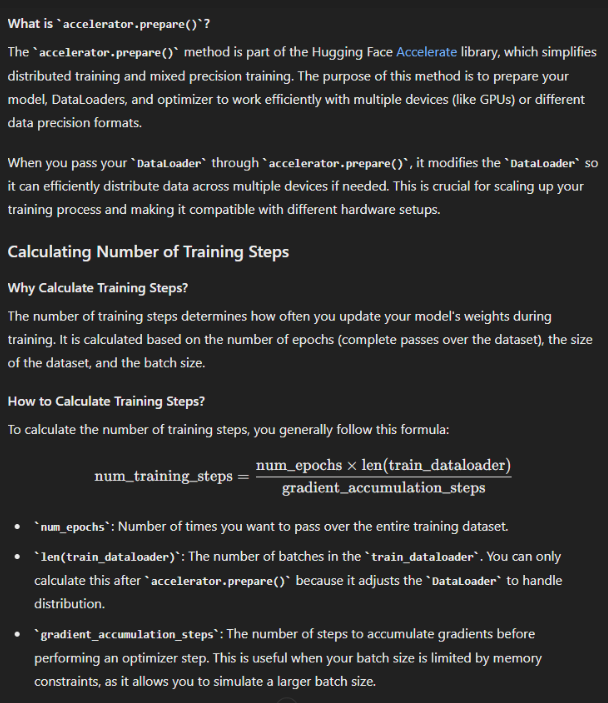

In [135]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [136]:
import subprocess

# Set Git configuration
subprocess.run(["git", "config", "--global", "user.name", "Jbryla9"], check=True)
subprocess.run(["git", "config", "--global", "user.email", "kubabp9@gmail.com"], check=True)

CompletedProcess(args=['git', 'config', '--global', 'user.email', 'kubabp9@gmail.com'], returncode=0)

In [137]:
from huggingface_hub import Repository, get_full_repo_name

model_name = "newsqa-custom_training_metrics"
repo_name = get_full_repo_name(model_name)
repo_name

'kubabp9/newsqa-custom_training_metrics'

In [138]:
output_dir = "newsqa-custom_training_metrics"
repo = Repository(output_dir, clone_from=repo_name)

c:\Users\Kuba\proba\.venv\Lib\site-packages\huggingface_hub\utils\_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
c:\Users\Kuba\Projects_LLM\Falcon_7b_ft\newsqa-custom_training_metrics is already a clone of https://huggingface.co/kubabp9/newsqa-custom_training_metrics. Make sure you pull the latest changes with `repo.git_pull()`.


In [1011]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    start_logits = []
    end_logits = []
    accelerator.print("Evaluation!")
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    start, end, metrics = compute_metrics(
        start_logits, end_logits, validation_dataset, raw_datasets["validation"]
    )
    print(f"epoch {epoch}:", metrics)

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

  0%|          | 0/74442 [00:00<?, ?it/s]

Evaluation!


  0%|          | 0/1404 [00:00<?, ?it/s]

  0%|          | 0/4212 [00:00<?, ?it/s]

epoch 0: {'exact_match': 51.94681861348528, 'f1': 66.455025209207}
Evaluation!


  0%|          | 0/1404 [00:00<?, ?it/s]

  0%|          | 0/4212 [00:00<?, ?it/s]

epoch 1: {'exact_match': 51.94681861348528, 'f1': 66.455025209207}
Evaluation!


  0%|          | 0/1404 [00:00<?, ?it/s]

  0%|          | 0/4212 [00:00<?, ?it/s]

epoch 2: {'exact_match': 51.94681861348528, 'f1': 66.455025209207}


### Testing

In [139]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "kubabp9/newsqa-custom_training_metrics"
question_answerer = pipeline("question-answering", model=model_checkpoint)

context = """
The 2024 Summer Olympics,[a] officially the Games of the XXXIII Olympiad[b] and branded as Paris 2024, were an international multi-sport event that occurred from 26 July to 11 August 2024 in France, with the opening ceremony having taken place on 26 July. Paris was the host city, with events (mainly football) held in 16 additional cities spread across metropolitan France, including the sailing centre in the second-largest city of France, Marseille on the Mediterranean Sea, as well as one subsite for surfing in Tahiti, French Polynesia.[4]

Paris was awarded the Games at the 131st IOC Session in Lima, Peru, on 13 September 2017. After multiple withdrawals that left only Paris and Los Angeles in contention, the International Olympic Committee (IOC) approved a process to concurrently award the 2024 and 2028 Summer Olympics to the two remaining candidate cities; both of the bids were praised for high technical plans and innovative ways to use a record-breaking number of existing and temporary facilities. Having previously hosted in 1900 and 1924, Paris became the second city ever to host the Summer Olympics three times (after London, which hosted the games in 1908, 1948, and 2012).[5][6] Paris 2024 marked the centenary of Paris 1924 and Chamonix 1924 (the first Winter Olympics), as well as the sixth Olympic Games hosted by France (three Summer Olympics and three Winter Olympics) and the first with this distinction since the 1992 Winter Games in Albertville. The Summer Games returned to the traditional four-year Olympiad cycle, after the 2020 edition was postponed to 2021 due to the COVID-19 pandemic.
"""
question = "How many times France hosted Olympics?"
question_answerer(question=question, context=context)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


{'score': 0.520162045955658, 'start': 1312, 'end': 1317, 'answer': 'sixth'}

In [140]:
question = "How many times Paris hosted Olympics?"
question_answerer(question=question, context=context)

{'score': 0.9387450814247131, 'start': 1122, 'end': 1127, 'answer': 'three'}

In [141]:
question = "When opening ceremony took place?"
question_answerer(question=question, context=context)

{'score': 0.9613287448883057, 'start': 248, 'end': 256, 'answer': '26 July.'}